# Machine Exercise 4
## Miguel Luis Martinez, Juan Carlos Roldan, Jeryl Salas | AI 221 WZZQ  Shannon Batch | University of the Philippines Diliman

In [ ]:
%pip install numpy pandas scikit-learn seaborn optuna

In [ ]:
# import dependencies
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from time import perf_counter

## Loading the Dataset

The 8x8 Handwritten Digits was loaded from the sklearn.datasets. It consists of 1797 samples of hand written digits that is mapped on an 8x8 grid and thus, it has a total of 64 features. We will perform a dimensional reduction technique called the Principal Component Analysis (PCA)

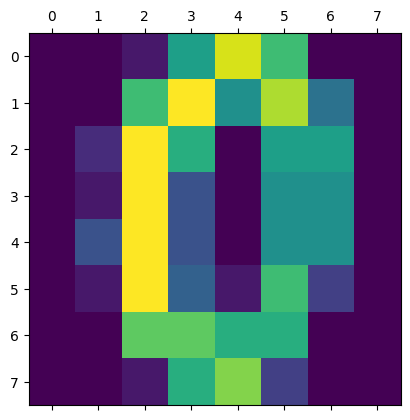

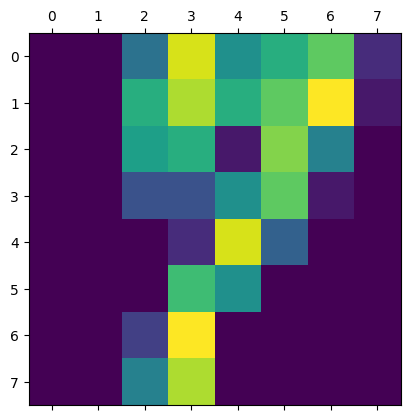

In [ ]:
digits = load_digits()

digits.data.shape
plt.matshow(digits.images[10])
plt.matshow(digits.images[472])

# This is an example image

In [ ]:
from sklearn.decomposition import PCA

X = digits.data
y = digits.target
display(X)
display(X.shape)
display(y)
display(y.shape)

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

(1797, 64)

array([0, 1, 2, ..., 8, 9, 8])

(1797,)

# 8x8 Handwritten Digits Visualization and Classification

## a. Visualize the projection of the dataset using PCA onto 1st 2 principal components
We first plot the PCA projection of the digits dataset onto the first 2 Principal Components. Each color in the plot corresponds to a digit class.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

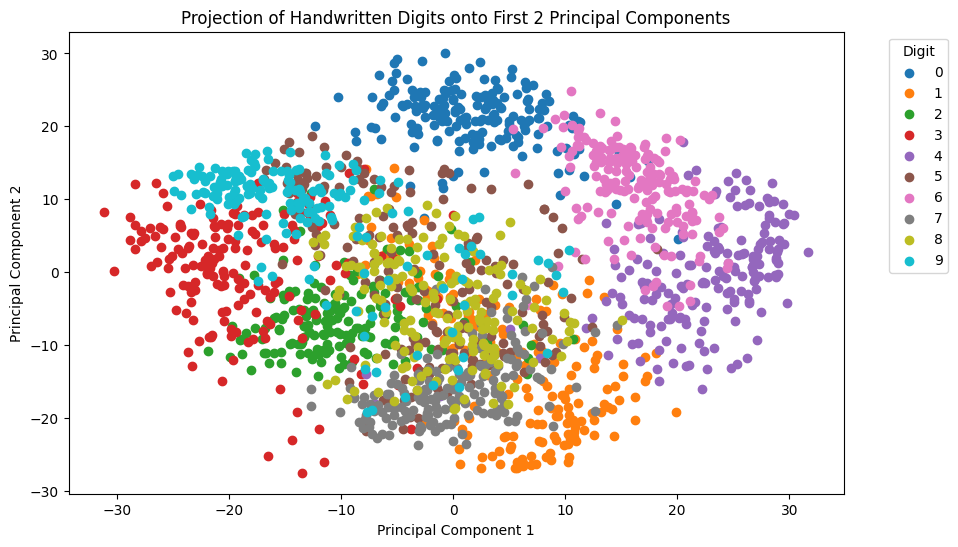

In [ ]:
plt.figure(figsize=[10,6])

for i in range(10):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=str(i))

plt.title('Projection of Handwritten Digits onto First 2 Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')


Next, we generate the explained variance ratio plot. Both principal components have a Cumulative Percent Variance of 28.51%.

The CPV at 2 PCs: 0.2851


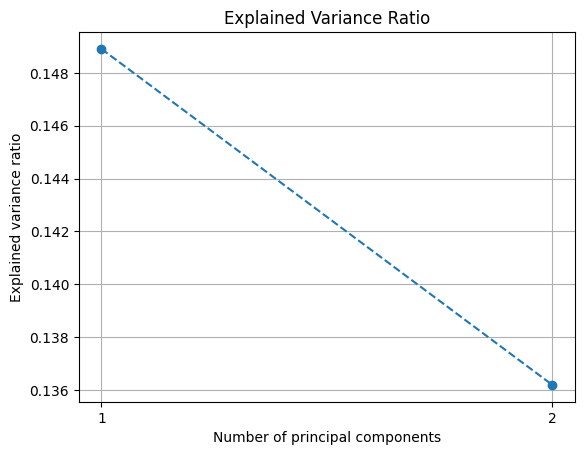

In [ ]:
plt.figure()
plt.plot(range(1,3), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance ratio')
plt.xticks(range(1,3))
plt.grid(True)

cpv_2pcs = sum(pca.explained_variance_ratio_[:2])
print(f"The CPV at 2 PCs: {cpv_2pcs:.4f}")
plt.show()

## b. PCA + SVM
In this part, we do the following:
* Split 2D data into 70% train and 30% test with stratification, random_state=0
* Train SVM with hyperparameter tuning
* Get classification accuracy for train and test datasets
* Get confusion matrix for train and test datasets


In [ ]:
# 2.
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


X = X_pca
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
print(X_train.shape)
print(X_test.shape)

(1257, 2)
(540, 2)


## Performing the SVM

After reducing the number of features to two principal components, we now performed the SVM with hyperparameter tuning. Optuna was used to find the optimal set of hyperparameters within 100 trials. The hyperparameters that were tuned were the regularization parameter C(from 0.1 to 10 in intervals of 0.1), the kernel (linear, rbf, or sigmoid), the kernel coefficient gamma (from 0.001 to 1), and a tolerance from (1e-10 to 1e-3). A random_state of 36 was chosen to randomly assign hyperparameters with initial values at the start of the tuning process.

As shown below the best classifier found was from trial 16 which uses Radial Basis Function as its kernel and had a regularization parameter of 7.3 and a kernel coefficient of 0.00128. The optimization for the hyperparameter lasted for 324.8757 seconds.

In [ ]:
import optuna
from optuna.samplers import TPESampler
import time
tune_seed = 42

start_time = time.time()
def objective(trial):
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    kernel = trial.suggest_categorical('kernel', ['linear','sigmoid', 'rbf'])
    degree = trial.suggest_int('degree', 1, 3, step=1)
    gamma = trial.suggest_float('gamma', 0.001, 1, log=True)
    tol = trial.suggest_float('tol', 1e-10, 1e-3, log=True)

    clf = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, tol=tol, random_state=36)
    clf = clf.fit(X_train, y_train.ravel())
    return clf.score(X_test, y_test.ravel())

study = optuna.create_study(direction='maximize',sampler=TPESampler(seed=tune_seed))
study.optimize(objective, n_trials=100)
best_params = study.best_params
opt_time = time.time() - start_time
print(f"Best parameters: {best_params}")
print(f"Total optimization time: {opt_time:.4f} seconds")


[I 2024-04-15 05:10:14,339] A new study created in memory with name: no-name-db6dbc18-ebdc-41ce-b3f5-161b2e3fa040
[I 2024-04-15 05:10:54,343] Trial 0 finished with value: 0.6092592592592593 and parameters: {'C': 3.8000000000000003, 'kernel': 'linear', 'degree': 1, 'gamma': 0.0029375384576328283, 'tol': 2.5502648504032847e-10}. Best is trial 0 with value: 0.6092592592592593.
[I 2024-04-15 05:10:54,481] Trial 1 finished with value: 0.09074074074074075 and parameters: {'C': 8.7, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 0.31428808908401085, 'tol': 3.064599841241147e-09}. Best is trial 0 with value: 0.6092592592592593.
[I 2024-04-15 05:10:54,548] Trial 2 finished with value: 0.6314814814814815 and parameters: {'C': 1.9000000000000001, 'kernel': 'rbf', 'degree': 2, 'gamma': 0.007476312062252299, 'tol': 1.9185373703841914e-06}. Best is trial 2 with value: 0.6314814814814815.
[I 2024-04-15 05:10:54,614] Trial 3 finished with value: 0.6351851851851852 and parameters: {'C': 1.4000000000000001,

Best parameters: {'C': 7.3, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.0012809969782194887, 'tol': 1.0117130558794823e-09}
Total optimization time: 324.8757 seconds


We then show the performance of the chosen classifier and as we can see below, the SVM after doing PCA performed a modest training accuracy of 68.26%, precision of 70.25% while it performed poorly on the test set with 64.44% accuracy and with 65.80% precision

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(f"Classifier Results on Train Set:")


best_model = SVC(**best_params)
best_model.fit(X_train, y_train.ravel())

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy: {train_accuracy * 100:.2f}%")
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Classifier Results on Train Set:
Training accuracy: 68.26%
Test accuracy: 64.44%


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

print(f"Classifier Results on Train Set:")
train_cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:")
print(train_cm)
print(f"Train Set Prediction Accuracy:{accuracy_score(y_train,y_train_pred):4f}")
print(f"Train Set Prediction Precision:{precision_score(y_train,y_train_pred,average='macro'):4f}")
print(f"Train Set Prediction Recall:{recall_score(y_train,y_train_pred,average='macro'):4f}")
print(f"Train Set Prediction F1 Score:{f1_score(y_train,y_train_pred,average='macro'):4f}")

Classifier Results on Train Set:
Confusion Matrix:
[[107   0   0   0   0   3  14   0   0   0]
 [  0  66   0   0   2  10   0   9  40   0]
 [  0   1  87   5   0   1   0   1  28   1]
 [  0   0  12  86   0   3   0   4   4  19]
 [  0   1   0   0 113   0  10   2   1   0]
 [  2   7   8   1   0  24   1  13  49  22]
 [  6   0   0   0  11   3 107   0   0   0]
 [  0   8   0   0   1   0   0 102  14   0]
 [  0   1   7   2   1   5   0  20  84   2]
 [  0   1   8   4   0  18   0   4   9  82]]
Train Set Prediction Accuracy:0.682578
Train Set Prediction Precision:0.702487
Train Set Prediction Recall:0.683265
Train Set Prediction F1 Score:0.680437


In [ ]:
print(f"Classifier Results on TestSet:")
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix for Test Set:")
print(test_cm)
print(f"Test Set Prediction Accuracy:{accuracy_score(y_test,y_test_pred):4f}")
print(f"Test Set Prediction Precision:{precision_score(y_test,y_test_pred,average='macro'):4f}")
print(f"Test Set Prediction Recall:{recall_score(y_test,y_test_pred,average='macro'):4f}")
print(f"Test Set Prediction F1 Score:{f1_score(y_test,y_test_pred,average='macro'):4f}")

Classifier Results on TestSet:
Confusion Matrix for Test Set:
[[49  0  0  0  0  1  4  0  0  0]
 [ 0 23  1  0  2  2  0 12 15  0]
 [ 0  0 36  5  0  0  0  2  8  2]
 [ 0  0  7 35  0  1  0  1  3  8]
 [ 0  2  1  0 43  0  7  1  0  0]
 [ 3  1  1  1  0 10  0 16 15  8]
 [ 1  0  0  0  4  0 48  0  1  0]
 [ 0  3  1  0  0  1  0 44  5  0]
 [ 0  5  5  0  0  6  0  8 27  1]
 [ 0  0  1  6  0  5  0  2  7 33]]
Test Set Prediction Accuracy:0.644444
Test Set Prediction Precision:0.658023
Test Set Prediction Recall:0.645336
Test Set Prediction F1 Score:0.638691


## c. Linear Discriminant Analysis
We now perform LDA with 2 components on the same 8x8 digit dataset so we can see if it performs better than the PCA + SVM method.

In [ ]:
# 3.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Data preparation

X = digits.data
y = digits.target

lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)

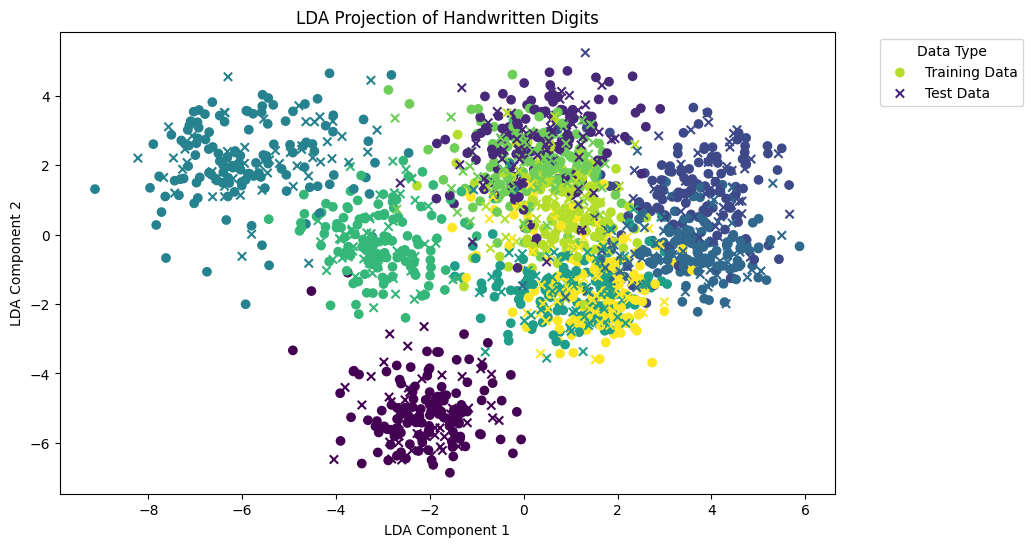

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.3, stratify=y, random_state=43)

plt.figure(figsize=(10,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label='Training Data')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', label='Test Data')
plt.title('LDA Projection of Handwritten Digits')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend(title='Data Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Performing the SVM

After reducing the number of features to two LDA components, we now performed the SVM with hyperparameter tuning same as the previous method. Optuna was used to find the optimal set of hyperparameters within 100 trials. The hyperparameters that were tuned have the same ranges as the first method with the regularization parameter C(from 0.1 to 10 in intervals of 0.1), the kernel coefficient gamma (from 0.001 to 1), a tolerance from (1e-10 to 1e-3), but this time we're now able to use poly as one of the kernels along with linear, rbf, and sigmoid as LDA has made the hyperparameter tuning much more efficient. A random_state of 36 was again chosen to randomly assign hyperparameters with initial values at the start of the tuning process.

As shown below the best classifier found was from trial 21 which uses Radial Basis Function as its kernel and had a regularization parameter of 7.2 and a kernel coefficient of 0.0064. The optimization for the hyperparameter lasted for 10.9032 seconds which is significantly faster than PCA+SVM

In [ ]:
start_time = time.time()
def objective(trial):
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'sigmoid', 'rbf'])
    degree = trial.suggest_int('degree', 1, 3, step=1)
    gamma = trial.suggest_float('gamma', 0.001, 1, log=True)
    tol = trial.suggest_float('tol', 1e-10, 1e-3, log=True)

    clf = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, tol=tol, random_state=36)
    clf = clf.fit(X_train, y_train.ravel())
    return clf.score(X_test, y_test.ravel())

study = optuna.create_study(direction='maximize',sampler=TPESampler(seed=tune_seed))
study.optimize(objective, n_trials=100)
best_params = study.best_params
opt_time = time.time() - start_time
print(f"Best parameters: {best_params}")
print(f"Total optimization time: {opt_time:.4f} seconds")

[I 2024-04-15 05:15:39,936] A new study created in memory with name: no-name-91a9249f-13ba-462e-be41-3e907eca61e5
[I 2024-04-15 05:15:40,015] Trial 0 finished with value: 0.7055555555555556 and parameters: {'C': 3.8000000000000003, 'kernel': 'linear', 'degree': 1, 'gamma': 0.0014936568554617625, 'tol': 0.00011567327199145979}. Best is trial 0 with value: 0.7055555555555556.
[I 2024-04-15 05:15:40,094] Trial 1 finished with value: 0.7055555555555556 and parameters: {'C': 6.1, 'kernel': 'sigmoid', 'degree': 1, 'gamma': 0.0035113563139704067, 'tol': 1.922346047064363e-09}. Best is trial 0 with value: 0.7055555555555556.
[I 2024-04-15 05:15:40,158] Trial 2 finished with value: 0.7129629629629629 and parameters: {'C': 3.1, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.007523742884534853, 'tol': 3.6688748954991754e-08}. Best is trial 2 with value: 0.7129629629629629.
[I 2024-04-15 05:15:40,214] Trial 3 finished with value: 0.7055555555555556 and parameters: {'C': 4.6, 'kernel': 'linear', 'degree'

Best parameters: {'C': 7.2, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.006447712341895527, 'tol': 1.2838586189237317e-06}
Total optimization time: 10.9032 seconds


From the results shown below, the LDA classifier has achieved much better results. In fact, it was able to achieve better results on the test set with an accuracy of 72.04% and a precision of 72.99% while only getting 71.76% accuracy and 72.26% on the training set

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix


best_model = SVC(**best_params)
best_model.fit(X_train, y_train.ravel())

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy: {train_accuracy * 100:.2f}%")
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Training accuracy: 71.76%
Test accuracy: 72.04%


In [ ]:
print(f"Classifier Results on Train Set:")
train_cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:")
print(train_cm)
print(f"Train Set Prediction Accuracy:{accuracy_score(y_train,y_train_pred):4f}")
print(f"Train Set Prediction Precision:{precision_score(y_train,y_train_pred,average='macro'):4f}")
print(f"Train Set Prediction Recall:{recall_score(y_train,y_train_pred,average='macro'):4f}")
print(f"Train Set Prediction F1 Score:{f1_score(y_train,y_train_pred,average='macro'):4f}")

Classifier Results on Train Set:
Confusion Matrix:
[[122   0   0   0   0   0   2   0   0   0]
 [  0  70   4   0   0   1   2  42   8   0]
 [  0   4  90  19   0   0   0   3   5   3]
 [  0   0  13 105   0   0   0   0   3   7]
 [  0   0   0   0 114   0  10   3   0   0]
 [  0   0   0   5   0  66   4   1   5  46]
 [  0   1   0   0   2   0 122   2   0   0]
 [  0  31   0   0   1   2   0  78  13   0]
 [  0   6   3   3   0   8   1  27  71   3]
 [  0   0   0   4   0  36   1   6  15  64]]
Train Set Prediction Accuracy:0.717582
Train Set Prediction Precision:0.722630
Train Set Prediction Recall:0.717303
Train Set Prediction F1 Score:0.717821


In [ ]:
print(f"Classifier Results on Test Set:")
test_cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(test_cm)
print(f"Test Set Prediction Accuracy:{accuracy_score(y_test,y_test_pred):4f}")
print(f"Test Set Prediction Precision:{precision_score(y_test,y_test_pred,average='macro'):4f}")
print(f"Test Set Prediction Recall:{recall_score(y_test,y_test_pred,average='macro'):4f}")
print(f"Test Set Prediction F1 Score:{f1_score(y_test,y_test_pred,average='macro'):4f}")

Classifier Results on Test Set:
Confusion Matrix:
[[54  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  1  2 17  3  0]
 [ 0  1 40  6  0  0  0  1  3  2]
 [ 0  0  7 34  0  2  0  0  3  9]
 [ 0  0  0  0 52  0  1  1  0  0]
 [ 1  0  2  0  0 28  0  0  6 18]
 [ 0  0  0  0  1  0 53  0  0  0]
 [ 0 10  0  0  1  0  2 36  5  0]
 [ 0  2  1  0  0  3  0 12 33  1]
 [ 0  0  0  2  0 12  0  2 11 27]]
Test Set Prediction Accuracy:0.720370
Test Set Prediction Precision:0.729895
Test Set Prediction Recall:0.720953
Test Set Prediction F1 Score:0.721322


# Question

Which of the two methods above (PCA+SVM vs LDA) is more preferable for the 8x8 Handwritten Digits classification? Use various aspects for comparison such as computational effort, human effort, model accuracy, interpretability, etc.


For the 8x8 Handwritten Digits classification, the level of human effort needed was the same for LDA and PCA+SVM but the LDA has outperformed PCA+SVM on every other aspect. In terms of computational efficiency, LDA with Optuna hyperparameter tuning performed took only 10.9032 seconds compared to 324.8757 seconds from the PCA+SVM. In terms of model accuracy, the LDA was able to perform better results with 72.04% on testing accuracy compared to 64.44% on the test set. We have also shown that the projection of LDA for handwritten digits is easier to interpret as there are less overlaps of classes compared to the PCA projection where there is significantly more overlaps of classes and thus harder to interpret on a 2d plane.

After all, LDA is a supervised linear transformation technique, used when there could be some linear relationships that researchers would like to explore. Versus PCA, LDA explicitly attempts to find linear relationships between the classes of data. Indirectly, this produces the *slightly* improved projection plot for LDA.

In conclusion, the LDA is more preferable for the 8x8 Handwritten Digits classification because of its efficiency and performance.